In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [282]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in xrange(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

 [Elemwise{exp,no_inplace}(<TensorType(float64, vector)>)]
Looping 1000 times took 3.517826 seconds
Result is [ 1.23178032  1.61879341  1.52278065 ...,  2.20771815  2.29967753
  1.62323285]
Used the cpu


In [9]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float64)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float64)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        print 'u', shape
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float64)


In [222]:
class Layer(object):
    def __init__(self, rng=None, name=""):
        self.name = name
        if rng is None:
            rng = numpy.random
        self.rng = rng
    
    @property
    def parameters(self):
        return []
    
    @property
    def parameter_names(self):
        return []
    
    def get_gradients(self, dLdY, fprop_context):
        return []
    
    def update(self, foo, alpha):
        return []
    def cost(self):
        return 0;
    
    
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out, gamma = None, n = "", weight_init=None, bias_init=None, **kwargs):
        super(AffineLayer, self).__init__(name= n, **kwargs)
        if weight_init is None:
            weight_init = Uniform(width = 0.1)
        if bias_init is None:
            bias_init = Constant(0.0)
        if gamma is None:
            self.gamma = theano.shared(0.1)
        else:
            self.gamma = theano.shared(gamma, name = self.name + " gamma")
        self.W = theano.shared(weight_init.generate(self.rng, (num_in, num_out)),name=self.name +" weight")
        self.b = theano.shared(bias_init.generate(self.rng, (num_out)), name=self.name +" bias")
    
    @property
    def parameters(self):
        return [self.W, self.b]
    @property
    def parametersValues(self):
        return [self.W.get_value(), self.b.get_value()]
    @property
    def parameter_names(self):
        return ['W','b']
    
    def build(self, X):
        print self.name+ " ",X.shape 
        return X.dot(self.W) + self.b
    def cost(self):
        return  (self.W ** 2).sum() * self.gamma
    def update(self, foo, alpha):
        gw, gb = T.grad(foo, self.parameters)
        return  [(self.W, self.W -alpha * gw), (self.b, self.b - alpha * gb)]
    
class LogRegLayer(Layer):
    def __init__(self, n = "", **kwargs):
        super(LogRegLayer, self).__init__(name = n, **kwargs)
    def build(self, X):
        return T.nnet.sigmoid(X)


class TanhLayer(Layer, ):
    def __init__(self, n = "", **kwargs):
        super(TanhLayer, self).__init__(name = n, **kwargs)
    def build(self, X):
        return T.tanh(X)

    
class ReLULayer(Layer):
    def __init__(self, n = "", **kwargs):
        super(ReLULayer, self).__init__(name = n, **kwargs)
    
    def build(self, X):
        return T.nnet.relu(X)

    
class SoftMaxLayer(Layer):
    def __init__(self, n = "", **kwargs):
        super(SoftMaxLayer, self).__init__(name = n, **kwargs)
    
    def build(self, X):
        return T.nnet.softmax(X)
    
class FeedForwardNet(object):
    def __init__(self, layers=None, alpha=0.1):
        if layers is None:
            layers = []
        self.layers = layers
        self.alpha = alpha
    
    def add(self, layer):
        self.layers.append(layer)
    
    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params
    
    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP[...] = newP
    
    @property
    def parameter_names(self):
        param_names = []
        for layer in self.layers:
            param_names += layer.parameter_names
        return param_names
    
    def build(self):
        x = T.matrix("x")
        y = T.vector("y", dtype='int64')
        cost = 0
        paramUpdates = []
        
        X = x
        
        for layer in self.layers:
            X = layer.build(X)
            cost += layer.cost()
        
        pred = np.argmax(X, 1)
        self.costFoo = T.nnet.categorical_crossentropy(X, y).mean() + cost
        
        for layer in self.layers:
            paramUpdates += layer.update(self.costFoo, self.alpha)
         
        self.train = theano.function(inputs=[x,y], 
                                    outputs=[pred, self.costFoo],
                                    updates=paramUpdates)
        self.predict  = theano.function(inputs=[x], 
                                    outputs=pred)
        
    
    @property
    def trainFunction(self):
        return self.train
    
    @property
    def predictFunction(self):
        return self.predict
    @property
    def costFunction(self):
        return self.costFoo


In [36]:
    def xent(x , y):
        return  -y * T.log(x) - (1-y) * T.log(1-x)
    
    def costF(x, w):
        return x.mean() + 0.01 * (w ** 2).sum()

In [37]:
from fuel.datasets.mnist import MNIST
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

MNIST.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}), 
    (Flatten, [], {'which_sources': 'features'}),
    (Mapping, [lambda batch: (b.T for b in batch)], {}) )

mnist_train = MNIST(("train",), subset=slice(None,50000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
mnist_train_stream = DataStream.default_stream(
    mnist_train,
    iteration_scheme=ShuffledScheme(mnist_train.num_examples, 100))

                         
mnist_validation = MNIST(("train",), subset=slice(50000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
mnist_validation_stream = DataStream.default_stream(
    mnist_validation, iteration_scheme=SequentialScheme(mnist_validation.num_examples, 250))
mnist_test = MNIST(("test",))
mnist_test_stream = DataStream.default_stream(
    mnist_test, iteration_scheme=SequentialScheme(mnist_test.num_examples, 250))

In [274]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}), 
    (Flatten, [], {'which_sources': 'features'}),
    (Mapping, [lambda batch: (b.T for b in batch)], {}) )

cifar10_train = CIFAR10(("train1",), subset=slice(None,10000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
cifar10_train_stream = DataStream.default_stream(
    cifar10_train,
    iteration_scheme=ShuffledScheme(cifar10_train.num_examples, 100))
                                               
cifar10_validation = CIFAR10(("train2",), subset=slice(None,10000))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
cifar10_validation_stream = DataStream.default_stream(
    cifar10_validation, iteration_scheme=SequentialScheme(cifar10_validation.num_examples, 250))
cifar10_test = CIFAR10(("test",))
cifar10_test_stream = DataStream.default_stream(
    cifar10_test, iteration_scheme=SequentialScheme(cifar10_test.num_examples, 250))

In [275]:
print "The streams return batches containing %s" % (mnist_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(mnist_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(mnist_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "CIFAR: "  
print "The streams return batches containing %s" % (cifar10_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (784, 100) containing float32
 - an array of size (1, 100) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (784, 250) containing float32
 - an array of size (1, 250) containing uint8
CIFAR: 
The streams return batches containing (u'batch1_features', u'batch1_targets')
Each trainin batch consits of a tuple containing:
 - an array of size (3072, 100) containing uint8
 - an array of size (1, 100) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (3072, 250) containing uint8
 - an array of size (1, 250) containing uint8


In [143]:
from sklearn import datasets
iris = datasets.load_iris()

#print iris

feats = 4
alpha = 0.01
pop_num = 150
rng = np.random
iris_f = iris['data'][:pop_num,:feats]
iris_t = iris['target'][:pop_num]
iris = hstack(([[x] for x in iris_t], iris_f))

rng.shuffle(iris)

#print iris

iris_train_f = iris[:2*pop_num/3,1:]
iris_train_t = np.array(iris[:2*pop_num/3, 0], dtype='uint8')
iris_test_f = iris[2*pop_num/3:,1:]
iris_test_t = np.array(iris[2*pop_num/3:, 0], dtype='uint8')

In [272]:
def compute_er(net, stream):
    num_errs = 0.0
    num_examples = 0
    for X, Y in stream.get_epoch_iterator():
        predictions = net.predictFunction(X.T)
        num_errs += (predictions != Y).sum()
        num_examples += X.shape[1]
    return num_errs/num_examples


In [281]:
import theano.printing as TP
from IPython.display import SVG
def svgdotprint(g):
    return SVG(theano.printing.pydotprint(g, return_image=True, format='svg'))
import time


feats = 3072
hidden1 = 500
hidden2 = 200
outs = 10
gamma = 0.0001
alpha = 0.001
num_epochs  = 100

net = FeedForwardNet([AffineLayer(feats, hidden, gamma, "fA"), 
                      TanhLayer("fTanh"),
                      AffineLayer(hidden1, hidden2, gamma, "sA"), 
                      TanhLayer("fTanh"),
                      AffineLayer(hidden2, outs, gamma, "tA"), 
                      SoftMaxLayer("fSoftMax")], alpha)
net.build()
print "Start"
print "gamma: ", gamma
print "alpha: ", alpha
i = 0
e = 0
while e < num_epochs:
    for X, Y in cifar10_train_stream.get_epoch_iterator():
        pr ,c = net.trainFunction(X.T, Y.ravel())
        i+=1
        if i % 100 == 0:
            print c, (pr  == Y).mean()
    
    print "After epoch: ", e, compute_er(net, cifar10_validation_stream)
    e+=1

u (3072, 500)
u (500, 200)
u (200, 10)
fA  Shape.0
sA  Shape.0
tA  Shape.0
Start
gamma:  0.0001
alpha:  0.001
2.41911071388 0.12
After epoch:  0 0.8608
2.43397561275 0.1
After epoch:  1 0.8284
2.37450479821 0.18
After epoch:  2 0.8026
2.33624778318 0.28
After epoch:  3 0.7801
2.37369939638 0.21
After epoch:  4 0.7767
2.32854698923 0.2
After epoch:  5 0.7629
2.26002768524 0.29
After epoch:  6 0.761
2.27938271596 0.29
After epoch:  7 0.748
2.2570439163 0.22
After epoch:  8 0.7414
2.25343617196 0.29
After epoch:  9 0.7411
2.21191922617 0.25
After epoch:  10 0.7365
2.2142542755 0.34
After epoch:  11 0.7279
2.17168345324 0.34
After epoch:  12 0.7286
2.21526886242 0.24
After epoch:  13 0.7203
2.15006709184 0.29
After epoch:  14 0.7157
2.17555201471 0.24
After epoch:  15

KeyboardInterrupt: 

In [277]:
feats = 784
hidden1 = 500
hidden2 = 200
outs = 10
gamma = 0.001
alpha = 0.1
num_epochs  = 100

net = FeedForwardNet([AffineLayer(feats, hidden, gamma, "fA"), 
                      TanhLayer("fTanh"),
                      AffineLayer(hidden1, hidden2, gamma, "sA"), 
                      TanhLayer("fTanh"),
                      AffineLayer(hidden2, outs, gamma, "tA"), 
                      SoftMaxLayer("fSoftMax")], alpha)
net.build()
print "Start"
i = 0
e = 0
while e < num_epochs:
    for X, Y in mnist_train_stream.get_epoch_iterator():
        pr ,c = net.trainFunction(X.T, Y.ravel())
        i+=1
        #if i % 100 == 0:
            #print c, (pr  == Y).mean()
    
    print "After epoch: ", e, compute_er(net, mnist_validation_stream)
    e+=1

    
for X, Y in mnist_validation_stream.get_epoch_iterator():
    predictions = net.predictFunction(X.T)
    num_errs += (predictions != Y).sum()
    num_examples += X.shape[1]
    k+=1
print num_errs, num_examples, k, num_errs/num_examples
#print (iris_test_t  == net.predictFunction(iris_test_f)).mean()

u (784, 500)
u (500, 200)
u (200, 10)
fA  Shape.0
sA  Shape.0
tA  Shape.0
Start
After epoch:  0 0.0828
After epoch:  1 0.0602
After epoch:  2 0.0525
After epoch:  3 0.0425
After epoch:  4 0.0397
After epoch:  5 0.0406
After epoch:  6 0.0331
After epoch:  7 0.0484
After epoch:  8 0.0304
After epoch:  9 0.0297


KeyboardInterrupt: 

In [266]:
import theano.printing as TP
from IPython.display import SVG
def svgdotprint(g):
    return SVG(theano.printing.pydotprint(g, return_image=True, format='svg'))



feats = 4
hidden = 500
outs = 3
gamma = 0.001
alpha = 0.1

net = FeedForwardNet([AffineLayer(feats, hidden, gamma, "fA"), 
          TanhLayer("fTanh"),
          AffineLayer(hidden, outs, gamma, "sA"), 
          SoftMaxLayer("fSoftMax")], alpha)




#theano.printing.pydotprint(costFoo, outfile="symbolic_graph_unopt.png", var_with_name_simple=True)  


net.build()

print iris_train_t
for i in range(10000):
    pr ,c = net.trainFunction(iris_train_f, iris_train_t)
    if i % 100 == 0:
        print c, (pr  == iris_train_t).mean()

print (pr  == iris_train_t).mean()
print pr

figure()
subplot(2,1,1)
scatter(iris_test_f[:,0], iris_test_f[:,1], c=iris_test_t.ravel(), cmap='prism')
subplot(2,1,2)
scatter(iris_test_f[:,0], iris_test_f[:,1], c=net.predicFunction(iris_test_f), cmap='prism')
print (iris_test_t  == net.predictFunction(iris_test_f)).mean()

u (4, 500)
u (500, 3)
fA  Shape.0
sA  Shape.0
[1 1 1 2 0 1 2 1 2 1 0 0 0 2 0 1 1 0 2 0 0 0 2 2 2 0 1 1 2 1 2 1 1 2 1 1 2
 1 2 0 2 2 2 1 2 2 2 1 1 1 0 2 2 2 1 0 0 1 2 0 0 1 0 2 0 0 1 2 0 1 0 2 1 2
 2 2 0 0 0 2 1 0 0 2 2 2 0 2 1 0 2 0 1 2 2 0 2 1 0 1]
1.09631703364 0.31
0.317733354127 0.86
0.197407528746 0.92
0.121202746755 0.99
0.105924980376 0.99
0.0999223132933 0.98
0.0966232818172 0.99
0.0943991315485 0.99
0.0927725225664 0.99
0.0915170037309 0.99
0.0905069747664 0.99
0.0896673708137 0.99
0.0889508866144 0.99
0.0883264893901 0.99
0.0877731482594 0.99
0.0872762028404 0.99
0.0868251649859 0.99
0.0864123427317 0.99
0.0860319563461 0.99
0.0856795586053 0.99
0.0853516479336 0.99
0.0850454062796 0.99
0.0847585190085 0.99
0.0844890494927 0.99
0.0842353506364 0.99
0.0839960016216 0.99
0.0837697620477 0.99
0.083555538178 0.99
0.0833523576834 0.99
0.0831593504002 0.99
0.0829757333839 0.99
0.082800799064 0.99
0.0826339056679 0.99
0.0824744693341 0.99
0.0823219575082 0.99
0.0821758833383 0.99
0.

KeyboardInterrupt: 

In [85]:
#print iris_test_t

w = theano.shared(rng.randn(feats)*0.01, name="w")
#print w.get_value()
b = theano.shared(0., name="b")
#print b.get_value()
x = T.matrix("x")
y = T.vector("y")

p_1 = T.nnet.sigmoid(T.dot(x, w) + b)   # Probability that target = 1
prediction = p_1 > 0.5                    # The prediction thresholded
c = costF(xent(p_1, y), w)# The cost to minimize
gw, gb = T.grad(c, [w, b])             # Compute the gradient of the cost
                                          # (we shall return to this in a
                                          # following section of this tutorial)

train = theano.function(
          inputs=[x,y],
          outputs=[prediction, c],
          updates=((w, w - alpha * gw), (b, b - alpha * gb)))
predict = theano.function(inputs=[x], outputs=prediction)



for i in range(1000):
    p, c =train(iris_train_f, iris_train_t)
    #print p, c, x.mean()
    
print (predict(iris_test_f) == iris_test_t).mean()


#foo = theano.function(inputs=[iris_train_f], outputs=[f])

#print iris_test_t
figure()
subplot(2,1,1)
scatter(iris_test_f[:,0], iris_test_f[:,1], c=iris_test_t.ravel(), cmap='spring')
subplot(2,1,2)
scatter(iris_test_f[:,0], iris_test_f[:,1], c=predict(iris_test_f).ravel(), cmap='spring')


TypeError: 'TensorVariable' object is not callable

u (4, 500)
u (500, 1)
The output file is available at symbolic_graph_unopt.png
1.0


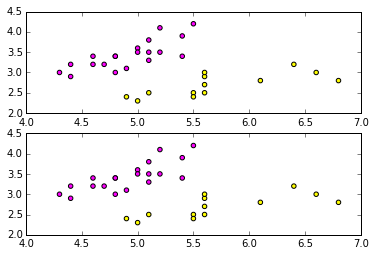

In [25]:
import theano.printing as TP
from IPython.display import SVG
def svgdotprint(g):
    return SVG(theano.printing.pydotprint(g, return_image=True, format='svg'))



x = T.matrix("x")
y = T.vector("y")
feats = 4
hidden = 500
outs = 1
gamma = 0.1
alpha = 0.1

fAL = AffineLayer(feats, hidden, gamma, "fA")
tL = TanhLayer()
sAL = AffineLayer(hidden, outs, gamma, "sA")
lL = LogRegLayer()

fa = fAL.build(x)
t = tL.build(fa)
sa = sAL.build(t)
out = lL.build(sa)
pred = out > 0.5
c = xent(out.ravel(), y).mean() + fAL.cost() + sAL.cost()

theano.printing.pydotprint(out, outfile="symbolic_graph_unopt.png", var_with_name_simple=True)  
fgw, fgb = T.grad(c, fAL.parameters)
sgw, sgb = T.grad(c, sAL.parameters)

train = theano.function(inputs=[x,y], 
                        outputs=[pred, c], 
                        updates=(fAL.update(c, alpha) + sAL.update(c, alpha)))
predict  = theano.function(inputs=[x], 
                        outputs=[pred])

for i in range(100):
    pr, cost = train(iris_train_f, iris_train_t)

print (pr.ravel() == iris_train_t).mean()


figure()
subplot(2,1,1)
scatter(iris_test_f[:,0], iris_test_f[:,1], c=iris_test_t.ravel(), cmap='spring')
subplot(2,1,2)
scatter(iris_test_f[:,0], iris_test_f[:,1], c=predict(iris_test_f), cmap='spring')





In [493]:
x1 = np.array([[12, 13], [1, 3]])
y1 = [1, 2]
print x.shape
y = T.vector()
x = T.matrix()
f = theano.function(inputs=[x, y], outputs=x+y)
f(x1, y1)


x2 = [1,2]
y2 = [2,3]
x2 + y2

Shape.0


[1, 2, 2, 3]